# CheXpert Data Exploration

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras_preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers

In [3]:
#read in the training dataset
train=pd.read_csv("CheXpert-v1.0-small/train.csv", dtype = str)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223414 entries, 0 to 223413
Data columns (total 19 columns):
Path                          223414 non-null object
Sex                           223414 non-null object
Age                           223414 non-null object
Frontal/Lateral               223414 non-null object
AP/PA                         191027 non-null object
No Finding                    22381 non-null object
Enlarged Cardiomediastinum    44839 non-null object
Cardiomegaly                  46203 non-null object
Lung Opacity                  117778 non-null object
Lung Lesion                   11944 non-null object
Edema                         85956 non-null object
Consolidation                 70622 non-null object
Pneumonia                     27608 non-null object
Atelectasis                   68443 non-null object
Pneumothorax                  78934 non-null object
Pleural Effusion              133211 non-null object
Pleural Other                 6492 non-null object

## Data Prep

In [4]:
## clean up the pathologies
pathology = ['No Finding','Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture','Support Devices']
#mapping to different labels
labelMap = {'0.0': 'NEG', '1.0' : 'POS', '-1.0' : 'UKN'}

# #remove the unknown class
# train = train[train['Pleural Effusion'] != '-1.0']

for p in pathology:
    train[p].loc[train[p].isna()] = '0.0'
    train[p] = train[p].map(labelMap)

    
##clean up the age to int then create buckets
train['Age'] = train['Age'].astype(str).astype(int)
age_buckets = [0, 2, 5, 13, 18, 33, 48, 64, 78, 98]
train['age_bucket'] = pd.cut(train['Age'], age_buckets)

train = train[train['Sex'] != 'Unknown']

##parse the path into the respective categories
new = train["Path"].str.split("/", n = 5, expand = True)

train['Folder'] = new[0]
train['Data'] = new[1]
train['Patient'] = new[2]
train['Study'] = new[3]
train['viewNumber']= new[4].str.split("_", n = 2, expand = True)[0]
train['ImageType']= new[4].str.split("_", n = 2, expand = True)[1]

train.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Pleural Other,Fracture,Support Devices,age_bucket,Folder,Data,Patient,Study,viewNumber,ImageType
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,POS,NEG,NEG,NEG,NEG,...,NEG,NEG,POS,"(64, 78]",CheXpert-v1.0-small,train,patient00001,study1,view1,frontal.jpg
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NEG,NEG,UKN,POS,NEG,...,NEG,POS,NEG,"(78, 98]",CheXpert-v1.0-small,train,patient00002,study2,view1,frontal.jpg
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NEG,NEG,NEG,POS,NEG,...,NEG,POS,NEG,"(78, 98]",CheXpert-v1.0-small,train,patient00002,study1,view1,frontal.jpg
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NEG,NEG,NEG,POS,NEG,...,NEG,POS,NEG,"(78, 98]",CheXpert-v1.0-small,train,patient00002,study1,view2,lateral.jpg
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NEG,NEG,NEG,NEG,NEG,...,NEG,NEG,NEG,"(33, 48]",CheXpert-v1.0-small,train,patient00003,study1,view1,frontal.jpg


## Age Buckets

[]

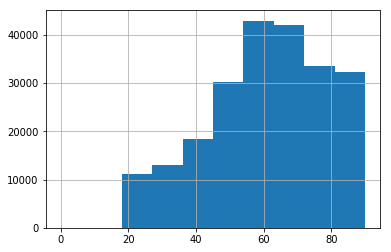

In [5]:
train['Age'].hist().plot()

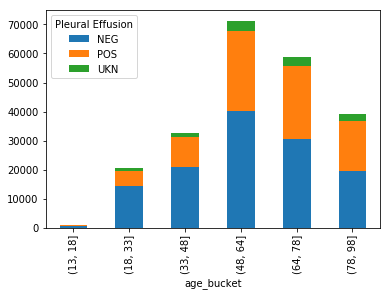

In [6]:
age_groups = train.groupby(['age_bucket', 'Pleural Effusion']).size().unstack()
age_groups.plot(kind="bar", stacked=True)

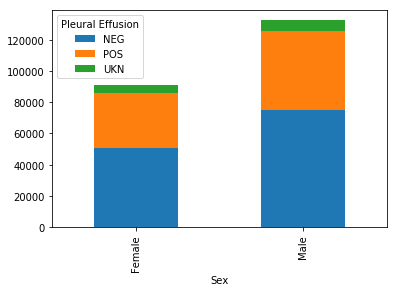

In [7]:
gender = train.groupby(['Sex','Pleural Effusion']).size().unstack()
gender.plot(kind="bar", stacked=True)

In [8]:
age_sex_groups = train.groupby(['age_bucket', 'Sex', 'Pleural Effusion']).size().unstack()
age_sex_groups

Pleural Effusion     NEG    POS   UKN
age_bucket Sex                       
(13, 18]   Female    194     85    11
           Male      343    119    14
(18, 33]   Female   5760   2193   338
           Male     8433   3208   500
(33, 48]   Female   8504   4207   580
           Male    12279   6207   896
(48, 64]   Female  15119  10586  1337
           Male    25063  17047  2188
(64, 78]   Female  11913  10079  1340
           Male    18557  15146  1859
(78, 98]   Female   9234   8065  1229
           Male    10196   9245  1336

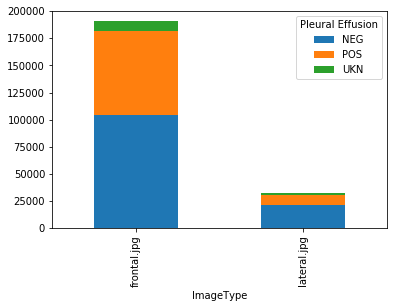

In [9]:
image_type = train.groupby(['ImageType', 'Pleural Effusion']).size().unstack()
image_type.plot(kind="bar", stacked=True)

In [10]:
patients = train.groupby(['Patient'])['Study'].nunique()
patients.head()

Patient
patient00001    1
patient00002    2
patient00003    1
patient00004    1
patient00005    2
Name: Study, dtype: int64

In [16]:
patients.count()

64539

<bound method Axes.plot of <matplotlib.axes._subplots.AxesSubplot object at 0x7f0301737b70>>

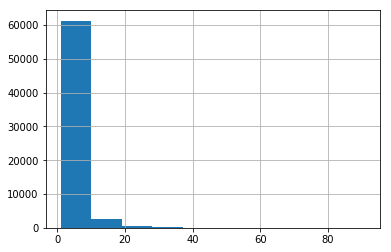

In [11]:
patients.hist().plot

In [14]:
patients.value_counts()

1     33563
2     11172
3      5921
4      3661
5      2482
6      1665
7      1181
8       896
9       696
10      529
11      448
12      345
13      280
14      236
15      186
16      178
17      146
18      121
19       96
20       93
21       67
23       63
22       49
25       44
26       41
27       37
24       36
28       30
32       27
30       25
      ...  
37        4
47        4
41        4
59        3
57        3
64        3
77        3
52        3
76        3
44        2
53        2
50        2
51        2
65        2
62        2
60        2
56        2
54        2
68        1
73        1
91        1
67        1
75        1
89        1
70        1
42        1
86        1
61        1
71        1
55        1
Name: Study, Length: 74, dtype: int64

In [46]:
pathology = ['No Finding','Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture','Support Devices']

for p in pathology:
    print(train[p].value_counts())

NEG    201033
POS     22380
Name: No Finding, dtype: int64
NEG    200212
UKN     12403
POS     10798
Name: Enlarged Cardiomediastinum, dtype: int64
NEG    188326
POS     27000
UKN      8087
Name: Cardiomegaly, dtype: int64
NEG    112234
POS    105581
UKN      5598
Name: Lung Opacity, dtype: int64
NEG    212739
POS      9186
UKN      1488
Name: Lung Lesion, dtype: int64
NEG    158183
POS     52246
UKN     12984
Name: Edema, dtype: int64
NEG    180888
UKN     27742
POS     14783
Name: Consolidation, dtype: int64
NEG    198604
UKN     18770
POS      6039
Name: Pneumonia, dtype: int64
NEG    156298
UKN     33739
POS     33376
Name: Atelectasis, dtype: int64
NEG    200820
POS     19448
UKN      3145
Name: Pneumothorax, dtype: int64
NEG    125598
POS     86187
UKN     11628
Name: Pleural Effusion, dtype: int64
NEG    217237
POS      3523
UKN      2653
Name: Pleural Other, dtype: int64
NEG    213731
POS      9040
UKN       642
Name: Fracture, dtype: int64
POS    116001
NEG    106333
UKN      

## Ground Truth Data

In [3]:
VALID = 'CheXpert-v1.0-small/valid.csv'

# generate validation set
valid = pd.read_csv(VALID, dtype=str)

##clean up the age to int then create buckets
valid['Age'] = valid['Age'].astype(str).astype(int)
age_buckets = [0, 2, 5, 13, 18, 33, 48, 64, 78, 98]
valid['age_bucket'] = pd.cut(valid['Age'], age_buckets)

##parse the path into the respective categories
new = valid["Path"].str.split("/", n = 5, expand = True)

valid['Folder'] = new[0]
valid['Data'] = new[1]
valid['Patient'] = new[2]
valid['Study'] = new[3]
valid['viewNumber']= new[4].str.split("_", n = 2, expand = True)[0]
valid['ImageType']= new[4].str.split("_", n = 2, expand = True)[1]

#mapping to different labels
label = {'0.0': 0, '1.0' : 1, '-1.0' : 1}

#same for validation set even though there should be no issue here with missing data
valid['label'] = valid['Pleural Effusion'].map(label)
num_valid = len(valid)

print(valid['label'].value_counts())

0    167
1     67
Name: label, dtype: int64


In [4]:
groupLabel = ['Patient','Study','Sex','Age']
test = valid[['Patient','Study','Sex','Age','label']].groupby(groupLabel).max().reset_index()

In [6]:
test['label'].value_counts()

0    136
1     64
Name: label, dtype: int64

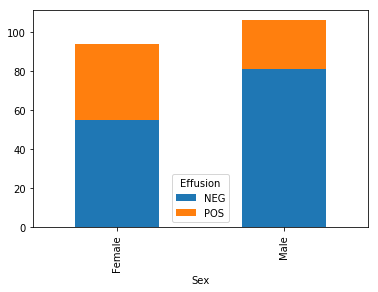

In [10]:
#mapping to different labels
label = {0: 'NEG', 1 : 'POS'}

#same for validation set even though there should be no issue here with missing data
test['Effusion'] = test['label'].map(label)
gender = test.groupby(['Sex','Effusion']).size().unstack()
gender.plot(kind="bar", stacked=True)